In [1]:
import numpy as np

# You must download the following data sets:
# Images: http://vision.stanford.edu/aditya86/ImageNetDogs/images.tar
# Annotation: http://vision.stanford.edu/aditya86/ImageNetDogs/annotation.tar

In [2]:
# pip install scikit-learn

# Lab Assignment Six: Convolutional Network Architectures

In this assignment, we will select a prediction task to perform on our dataset, evaluate a deep learning architecture and tune hyper-parameters.

**Dataset Selection**
The dataset must be image data. We will multi-class classification.

## Preparation

#### **[1.5 points]** Choose and explain what metric(s) you will use to evaluate your algorithm’s performance. You should give a detailed argument for why this (these) metric(s) are appropriate on your data. That is, why is the metric appropriate for the task (e.g., in terms of the business case for the task). Please note: rarely is accuracy the best evaluation metric to use. Think deeply about an appropriate measure of performance.

1.) talk about how we will be using accuracy score because is good and even number of classes and becuz not super important to not get things wring vs correct

In [3]:
from sklearn import datasets, metrics
from sklearn.model_selection import train_test_split
import numpy as np
import tensorflow as tf
from matplotlib import pyplot as plt

import tensorflow.keras as keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Reshape
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D

keras.__version__

'2.4.0'

In [4]:
# tf.config.list_physical_devices('GPU')
print("Num of GPUs available: ", len(tf.test.gpu_device_name()))


Num of GPUs available:  13


In [5]:
from tensorflow.keras.datasets import cifar10
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

print(f'X_train: {X_train.shape}')
print(f'y_train: {y_train.shape}')
print(f'X_test: {X_test.shape}')
print(f'y_test: {y_test.shape}')

print('Unique classes: ',end='')
print(np.unique(y_train))

NUM_CLASSES = len(np.unique(y_train))

X_train,X_valid, y_train, y_valid = train_test_split(X_train,y_train,train_size=0.9)

y_train_ohe = keras.utils.to_categorical(y_train, NUM_CLASSES)
y_test_ohe = keras.utils.to_categorical(y_test,NUM_CLASSES)
y_valid_ohe = keras.utils.to_categorical(y_valid,NUM_CLASSES)

print(np.unique(y_train,return_counts=True))

X_train: (50000, 32, 32, 3)
y_train: (50000, 1)
X_test: (10000, 32, 32, 3)
y_test: (10000, 1)
Unique classes: [0 1 2 3 4 5 6 7 8 9]
(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8), array([4486, 4496, 4515, 4503, 4491, 4491, 4489, 4512, 4494, 4523]))


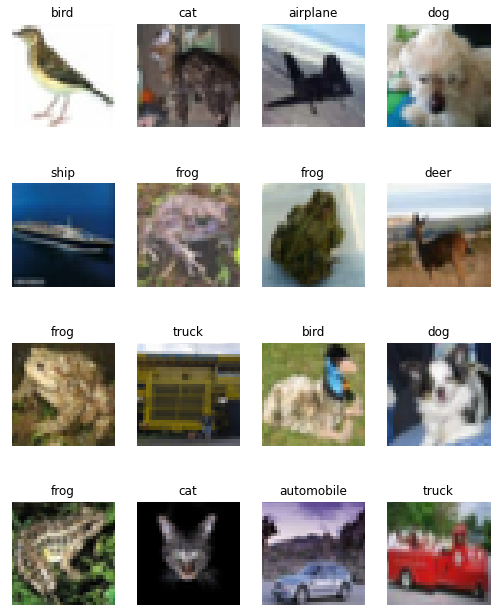

In [6]:

plt.style.use('ggplot')

def plot_gallery(images, titles, h, w, n_row=3, n_col=6,alt_labels=None):
    """Helper function to plot a gallery of portraits"""
    plt.figure(figsize=(1.7 * n_col, 2.3 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i].squeeze())
        plt.title(alt_labels[titles[i][0]], size=12)
        plt.xticks(())
        plt.yticks(())



labels = {
    0: 'airplane',
    1:	'automobile',
    2:	'bird',
    3:	'cat',
    4:	'deer',
    5:	'dog',
    6:	'frog',
    7:	'horse',
    8:	'ship',
    9:	'truck'
}


plot_gallery(X_train, y_train, 32, 32,alt_labels=labels,n_col=4,n_row=4)




#### **[1.5 points]** Choose the method you will use for dividing your data into training and testing (i.e., are you using Stratified 10-fold cross validation? Shuffle splits? Why?). Explain why your chosen method is appropriate or use more than one method as appropriate. Convince me that your cross validation method is a realistic mirroring of how an algorithm would be used in practice.

Now we need to make sure that the data is scaled correctly before being placed into our network

In [7]:
print(f'Max Before Scale: {np.max(X_train.max())}')
print(f'Max Before Scale: {np.min(X_train.min())}')
print(f'Shape before Scale: {X_train.shape}')

X_train_orig = X_train.copy()

X_test_orig = X_test.copy()

X_train = (X_train / 255.0)

X_test = (X_test / 255.0)
X_valid = (X_valid / 255.0)
print(f'Max After Scale: {np.max(X_train.max())}')
print(f'Max Before Scale: {np.min(X_train.min())}')
print(f'Shape after Scale: {X_train.shape}')
# plot_gallery(X_train * 255.0 + 0.5, y_train, 32, 32,alt_labels=labels,n_col=4,n_row=4)

Max Before Scale: 255
Max Before Scale: 0
Shape before Scale: (45000, 32, 32, 3)
Max After Scale: 1.0
Max Before Scale: 0.0
Shape after Scale: (45000, 32, 32, 3)


We gonna be using stratified 10 fold becuase Idk why we would any other one 

In [8]:

from sklearn.model_selection import StratifiedKFold
from sklearn import metrics as mt


def simple_eval(model, train_X, train_y, test_X, test_y,model_args=None):
    mets = {}
    print("=====================",model_args)
    model.fit(train_X,train_y,**model_args)
    
    
    yhat = np.argmax(model.predict(X_test), axis=1)
    acc = mt.accuracy_score(y_test,yhat)
    mets['accuracy'] = acc

    
    return model,mets
    

def basic_model():
    cnn3 = Sequential()
    num_filt_layers = [32, 32]
    for num_filters in num_filt_layers:
        cnn3.add( Conv2D(filters=num_filters, 
                        kernel_size=(3,3), 
                        padding='same',
                        input_shape=(32,32,3)
                        ) )
        cnn3.add( Activation('relu'))
        cnn3.add( MaxPooling2D(pool_size=(2, 2)) )
        

    # add one layer on flattened output
    cnn3.add( Flatten() )
    cnn3.add( Dense(NUM_CLASSES) )
    cnn3.add( Activation('softmax') )

    # Let's train the model 
    cnn3.compile(loss='mean_squared_error',
                optimizer='rmsprop',
                metrics=['accuracy'])
    return cnn3

def custom_k_folds(X, y, n_folds=10, create_model=basic_model, train_eval_model=simple_eval,model_args=None):

    skf = StratifiedKFold(n_splits=n_folds, shuffle=True)
    
    y_ohe = keras.utils.to_categorical(y, NUM_CLASSES)
    
    iterations = []
    for i, (train_index, test_index) in enumerate(skf.split(X, y)):
        val = {}
        print("Running Fold", i+1, "/", n_folds)
        model = None # Clearing the NN.
        model = create_model()
        
        


        # print(np.unique(y[train_index]))
        model, mets = train_eval_model(model, X[train_index], y_ohe[train_index], X[test_index], y_ohe[test_index],model_args=model_args)
        
        val['model'] = model
        val['metrics'] = mets
        iterations.append(val)

    return iterations
            

args = {'batch_size':32, 
        'epochs':10, 
        'shuffle':True, 
        'verbose':1}




# vals = custom_k_folds(X_train,y_train,model_args=args)


In [9]:
import pprint
# pp = pprint.PrettyPrinter(indent=1)

# pp.pprint(vals)

In [10]:
import seaborn as sns

def generate_bar(result, metric):
    plt.style.use("ggplot")
    

    plt.title
    x_coord = [i for i in range(len(result))]
    y_val = [val['metrics'][metric] for val in result]
    plt.title(f'{np.average(y_val):0.2f} average {metric}')
    plt.bar(x_coord,y_val,label=labels)
    
    plt.xlabel('Fold #')
    plt.ylabel(metric)
    
    plt.show()
    

# generate_bar(vals,'accuracy')





## Modeling

Our previous model was pretty terrible, only 68% average accuracy, but that was also a very __very__ simple network. Lets continue using the k-fold cross validation, but lets up the power of our model.

In [11]:
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras import backend as K

def moderate_model():
    
    cnn4 = Sequential()
    
#     cnn4.add(Conv2D(filters=50,kernel_size=(3,3),padding='same'))
#     cnn4.add(BatchNormalization())
#     num_filt_layers = [32, 32,16]
#     max_pools = [(2,2),(2,2),(2,2)]
    
#     for i,num_filters in enumerate(num_filt_layers):
#         cnn4.add( Conv2D(filters=num_filters, 
#                         kernel_size=(3,3), 
#                         padding='same'))
        
#         cnn4.add( Activation('relu'))
#         cnn4.add( MaxPooling2D(pool_size=max_pools[i]))


#     # add one layer on flattened output
#     cnn4.add( Flatten() )
#     cnn4.add( Dense(30) )
#     cnn4.add(Activation('relu'))
#     cnn4.add( Dense(NUM_CLASSES) )
#     cnn4.add( Activation('softmax') )
    
#     cnn4.compile(loss='mean_squared_error',
#               optimizer='rmsprop',
#               metrics=['accuracy'])

    cnn4.add(Conv2D(75,(3,3), strides=1, padding='same'))
    cnn4.add(Activation('relu'))
    cnn4.add(BatchNormalization())
    cnn4.add(MaxPooling2D((2,2), strides=2,padding='same'))
    cnn4.add(Conv2D(50,(3,3), strides=1, padding='same'))
    cnn4.add(Activation('relu'))
    cnn4.add(Dropout(0.2))
    cnn4.add(BatchNormalization())
    cnn4.add(MaxPooling2D((2,2),strides=1,padding='same'))
    cnn4.add(Activation('relu'))
    cnn4.add(BatchNormalization())
    cnn4.add(MaxPooling2D((2,2),strides=2,padding='same'))
#     cnn4.add(Dropout(0.3))
    cnn4.add(Flatten())
    cnn4.add(Dense(units=512,activation='relu'))
    cnn4.add(Dense(units=NUM_CLASSES))
    cnn4.add(Activation('softmax'))
    cnn4.compile(loss='categorical_crossentropy',
                optimizer='adam',
                metrics=['accuracy'])
    return cnn4



model = moderate_model()

# y_train_ohe = np.astype('float16')
print("Learning rate before first fit:", model.optimizer.learning_rate.numpy())


model.fit(X_train,y_train_ohe,
         batch_size=32,
         epochs=10,
         shuffle=True,
         verbose=1,
         validation_data=(X_valid,y_valid_ohe))

K.set_value(model.optimizer.learning_rate, 0.0001)

model.fit(X_train,y_train_ohe,
         batch_size=32,
         epochs=15,
         shuffle=True,
         verbose=1,
        initial_epoch=10
         validation_data=(X_valid,y_valid_ohe))

# vals = custom_k_folds(X_train,y_train,model_args=args,create_model=moderate_model)



Learning rate before first fit: 0.001
Epoch 1/25
1407/1407 [==============================] - 6s 3ms/step - loss: 1.5425 - accuracy: 0.4733 - val_loss: 1.0639 - val_accuracy: 0.6318
Epoch 2/25
1407/1407 [==============================] - 3s 2ms/step - loss: 0.8856 - accuracy: 0.6914 - val_loss: 0.9467 - val_accuracy: 0.6722
Epoch 3/25
1407/1407 [==============================] - 3s 2ms/step - loss: 0.6789 - accuracy: 0.7665 - val_loss: 0.9062 - val_accuracy: 0.6856
Epoch 4/25
1407/1407 [==============================] - 3s 2ms/step - loss: 0.5312 - accuracy: 0.8189 - val_loss: 0.8891 - val_accuracy: 0.6954
Epoch 5/25
1407/1407 [==============================] - 3s 2ms/step - loss: 0.4098 - accuracy: 0.8643 - val_loss: 0.8476 - val_accuracy: 0.7104
Epoch 6/25
1407/1407 [==============================] - 3s 2ms/step - loss: 0.3180 - accuracy: 0.9005 - val_loss: 0.9040 - val_accuracy: 0.7056
Epoch 7/25
1407/1407 [==============================] - 3s 2ms/step - loss: 0.2427 - accuracy: 0.9

#### **[1.5 points]**  Setup the training to use data expansion in Keras (also called data augmentation). Explain why the chosen data expansion techniques are appropriate for your dataset. You can use the keras ImageGenerator as a pre-processing step OR in the optimization loop. You can also use the Keras-cv augmenter (a separate package: https://keras.io/keras_cv/.)

In [12]:
yhat = model.predict(X_test)

yhat_mlp = np.argmax(yhat, axis=1)
acc_mlp = mt.accuracy_score(y_test,yhat_mlp)

cm = mt.confusion_matrix(y_test,yhat_mlp)


acc_mlp

0.7328

[3 8 8 ... 5 1 7]


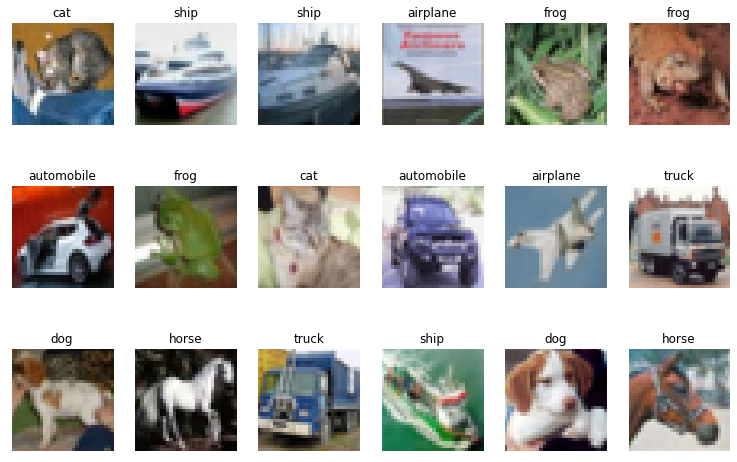

In [13]:
plot_gallery(X_test,np.argmax(yhat,axis=1).reshape(-1,1),h=32,w=32,alt_labels=labels)


print(np.argmax(yhat,axis=1))

In [14]:
from tensorflow.keras.utils import plot_model

# you will need to install pydot properly on your machine to get this running
plot_model(
    model, to_file='model.png', show_shapes=True, show_layer_names=True,
    rankdir='LR', expand_nested=False, dpi=96
)

('Failed to import pydot. You must `pip install pydot` and install graphviz (https://graphviz.gitlab.io/download/), ', 'for `pydotprint` to work.')


In [75]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(
    featurewise_center=False,
    featurewise_std_normalization=False,
    rotation_range=45,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    validation_split=0.2)
# compute quantities required for featurewise normalization
# (std, mean, and principal components if ZCA whitening is applied)
datagen.fit(X_train_orig)
# fits the model on batches with real-time data augmentation:


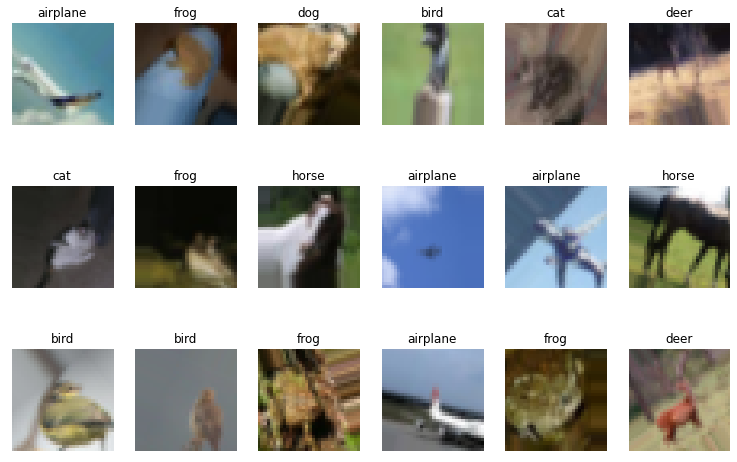

In [77]:
tmp_x = datagen.flow(X_train_orig,y_train,batch_size=64,subset='training')


gen_data = tmp_x.next()

generated_labels = gen_data[1]
generated_imgs = gen_data[0]

generated_labels = np.array(generated_labels)


plot_gallery(generated_imgs/255.0,generated_labels,h=32,w=32,alt_labels=labels)


#### **[2 points]** Create a convolutional neural network to use on your data using Keras. Investigate at least two different convolutional network architectures (and investigate changing some parameters of each architecture such as the number of filters--at minimum have two variations of each network for a total of four models trained). Use the method of train/test splitting and evaluation metric that you argued for at the beginning of the lab. Visualize the performance of the training and validation sets per iteration (use the "history" parameter of Keras). Be sure that models converge. 

In [ ]:
# One of the models can be the moderate_model Function
#Make sure to use the generated/altered images not just the pure ones
# Maybe build a pipeline for this, prolly gonna make life easier ^

#### **[1.5 points]** Visualize the final results of the CNNs and interpret/compare the performances. Use proper statistics as appropriate, especially for comparing models.

#### **[1 points]** Compare the performance of your convolutional network to a standard multi-layer perceptron (MLP) using the receiver operating characteristic and area under the curve. Use proper statistical comparison techniques.  

## Exceptional Work

#### One idea (required for 7000 level students): Use transfer learning to pre-train the weights of your initial layers of your CNN. Compare the performance when using transfer learning to training without transfer learning (i.e., compare to your best model from above) in terms of classification performance. 